# Notebook pt 4 - Displaying Scatter Diagrams based on histogram widths

# Section 1: Set Up

As explained in Notebook pt 1, we must install the nessecary packages and load in the data fits files. The first few code segments parallel previous notebooks.

In [1]:
import aplpy
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
from matplotlib.scale import SymmetricalLogTransform, InvertedSymmetricalLogTransform
from scipy.stats import gaussian_kde
import seaborn as sns
from heapq import nsmallest



SymlogScaling = SymmetricalLogTransform(10, 2, 1).transform
InverseSymlogScaling = InvertedSymmetricalLogTransform(10, 2, 1).transform


# initialize plot settings
mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['patch.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['axes.linewidth'] = 2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.pad'] = 5

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5

mpl.rcParams['figure.figsize'] = (10, 10/1.6)


# read the spectral cubes

Map12CO = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\oriona_12co_XYV_smo60_int-70-125_resa.fits')[0]
Map13CO = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\oriona_13co_XYV_smo60_int-70-125_resa.fits')[0]
MapC18O = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_c18o_smo60_int-490-565.fits')[0] 
MapHCN = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_hcn_smo60_int-440-585.fits')[0]
MapN2Hp = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_n2hp_smo60_int-450-590.fits')[0]
MapCN = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_cn_smo60_int-tot.fits')[0]
MapCCH = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_c2h_smo60_int-470-650.fits')[0]

NoiseLine = {'12CO': 0.94 * 0.2 * sqrt(125.-70.) * 52.*(100./115.)/60.,
             '13CO': 0.28 * 0.2 * sqrt(125.-70.) * 52.*(100./110.)/60.,
             'C18O': 0.17549,
             'HCN': 0.52463,
             'N2H+': 0.32648,
             'CN': 0.70422,
             'CCH': 0.45627}
for Index in NoiseLine.keys():
    NoiseLine[Index] = NoiseLine[Index]
    
    

# Section 2: Re-cap and purpose

The previous notebook's main program is going to be the basis from which we draw for this program. In the previous notebook, we ranked the histograms made from the ratio of the intensities in increasing order based on the width of the histogram at 10% of the maximum. We normalized the plots on both the x and y axis, as well as smoothing the histograms from noise and decreasing bin size. Almost all of that program will be used in the program below.

The purpose of this program is to rank the relative similarities between the pairs of emmision lines as they are displayed in the scatter plot. As explained in Notebook 3, the computer does not know how to automatically rank the scatter plots, as one slope does not acurately encompass all of the points on a complex scatter diagram. Although the histogram is currently being ranked in increasing order, the original purpose was to figure out how to rank the scatter diagrams. This program works to do this using the information collected from the histograms.

From a process standpoint, the program uses the histograms to rank the scatter diagram. It does this by taking two intensity lines and making a histogram. Then, the program finds the width of the histogram at 10% of the maximum (lets refer to that number as n). The program then ranks the histograms by the increasing of n. However, since we do not want the histograms, we do not have the program show the histograms. Instead, we have a function that collects the information for the histograms (which pair goes first based on the n order) and saves that information. Finally, we have a function that goes through that information and displays the scatter plots in the n order with the correct x and y axis.

# Section 3: Main Program

## Subsection a: Basic Functions

The first few functions are the exact same as the functions used in Notebook pt 3. Refer there for further explaination.

In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return array[idx]

fwm_info = []

In [3]:
data_dictionary = [
{"data_set": Map12CO.data,"title": '$^{12}CO$' , "standardized_color": 'pink' , "noiseline": 1.05073560014},
{"data_set": Map13CO.data, "title": '$^{13}CO$' , "standardized_color": 'red' , "noiseline": 0.3272},
{"data_set": MapC18O.data, "title": '$C^{18}O$' , "standardized_color": 'orange' , "noiseline": 0.17549},
{"data_set": MapN2Hp.data, "title": '$N_2H^+$' , "standardized_color": 'brown' , "noiseline": 0.32648},
{"data_set": MapHCN.data, "title": 'HCN' , "standardized_color": 'blue' , "noiseline": 0.52463},
{"data_set": MapCN.data, "title": 'CN' , "standardized_color": 'green' , "noiseline": 0.70422},
{"data_set": MapCCH.data, "title": 'CCH' , "standardized_color": 'purple' , "noiseline": 0.45627}]


for x_index in range(len(data_dictionary)):
    data_dictionary[x_index]['brightness'] = np.sum((data_dictionary[x_index]['data_set'] / data_dictionary[x_index]['noiseline']) > 3)
    #print(data_dictionary[x_index]['brightness'])

    
list_of_x = sorted(data_dictionary, key=lambda d: d['brightness'], reverse=True) 

'''for x_index in range(len(list_of_x)):
    print(list_of_x[x_index]['brightness'])'''


"for x_index in range(len(list_of_x)):\n    print(list_of_x[x_index]['brightness'])"

In [4]:
class variables:
    a=0

def function_pt_1():
    variables.Data1 = variables.x_array['data_set'].flatten()
    variables.Data2 = variables.y_array['data_set'].flatten()  
        
    variables.Data1[variables.Data1 < 3.0 * variables.x_array['noiseline']] = np.nan
    variables.Data2[variables.Data2 < 3.0 * variables.y_array['noiseline']] = np.nan
    
    variables.x_noiseline = variables.x_array['noiseline']
    variables.y_noiseline = variables.y_array['noiseline']
        
    variables.x_title = variables.x_array['title']
    variables.x_color = variables.x_array['standardized_color']
    variables.y_title = variables.y_array['title']
    variables.y_color = variables.y_array['standardized_color']
       

def function_pt_2():
    variables.Intensity_ratio = variables.Data2/variables.Data1
    variables.Median = np.nanmedian(variables.Intensity_ratio)
    variables.Normalized_ratio = variables.Intensity_ratio/variables.Median
    
    
    variables.Histogram1, variables.bins1 = np.histogram(variables.Normalized_ratio, bins=np.arange(-1,10,0.05))
    variables.Histogram1_smoothed = variables.Histogram1

def function_pt_3():
    variables.center_10 = (variables.bins1[:-1] + variables.bins1[1:]) * 0.1
    
    variables.index_at_max_y_for_histogram_1 = np.nanmax(np.where(variables.Histogram1_smoothed == np.nanmax(variables.Histogram1_smoothed))[0])
    
    variables.left_of_the_center_array = variables.Histogram1_smoothed[:variables.index_at_max_y_for_histogram_1]
    variables.right_of_the_center_array = variables.Histogram1_smoothed[variables.index_at_max_y_for_histogram_1:]

def function_pt_4():
    variables.max10_of_left_of_the_center_array = find_nearest(variables.left_of_the_center_array, np.nanmax(variables.Histogram1_smoothed)/10)
    variables.max10_of_right_of_the_center_array = find_nearest(variables.right_of_the_center_array, np.nanmax(variables.Histogram1_smoothed)/10)
    variables.index_of_left_of_the_center_array_10 = (np.where(variables.left_of_the_center_array == variables.max10_of_left_of_the_center_array))[0]
    variables.index_of_right_of_the_center_array_10 = (np.where(variables.right_of_the_center_array == variables.max10_of_right_of_the_center_array))[0]
    

def function_pt_5():
    variables.left_side_10 = variables.center_10[variables.index_of_left_of_the_center_array_10]
    variables.right_side_10 = variables.center_10[(variables.index_of_right_of_the_center_array_10 + variables.index_at_max_y_for_histogram_1)]

def function_pt_6():
    variables.fw10m = np.nanmax(variables.right_side_10) - np.nanmax(variables.left_side_10)
    variables.fw10m_scaled_by_left_bin = variables.fw10m / np.nanmax(variables.right_side_10)
    variables.median_of_sides = (np.nanmax(variables.right_side_10) + np.nanmax(variables.left_side_10)) / 2
    variables.fw10m_scaled_by_median_of_the_bins = variables.fw10m / variables.median_of_sides
    variables.fw10m_scaled_by_maximum = variables.fw10m / np.nanmax(variables.Histogram1_smoothed)

def function_pt_7():
    variables.title_text = variables.x_title + ' divided by ' + variables.y_title
    variables.histogram = (variables.Histogram1_smoothed)/np.nanmax(variables.Histogram1_smoothed)

def function_pt_8():
    variables.fwhm = 10
    variables.return_dictionary = {"title_text": variables.title_text, "x_label": variables.x_title, "y_label": variables.y_title, 
                               "y_color": variables.y_color, "histogram": variables.histogram,
                   "fwhm": variables.fwhm, "fw10m_scaled_by_median_of_the_bins": variables.fw10m_scaled_by_median_of_the_bins, 
                               "fw10m_scaled_by_maximum": variables.fw10m_scaled_by_maximum, 
                   "center_10": variables.center_10, "x_data": variables.Data1, "y_data": variables.Data2,
                             "x_noiseline": variables.x_noiseline, "y_noiseline": variables.y_noiseline}

def plot_normalized_intensity_versus_density(x_array, y_array):
    variables.x_array = x_array
    variables.y_array = y_array
    
    function_pt_1()
    function_pt_2()
    function_pt_3()
    function_pt_4()
    function_pt_5()
    function_pt_6()
    function_pt_7()
    function_pt_8()
    
    return variables.return_dictionary


The only difference is that we do not actually show the histograms in the 'print_charts' function. I am noting this as it is the only way this program's 'print_charts' function does not paralell the previous Notebook's 'print_charts' program.

In [5]:
def print_charts(return_dictionary, chart_type):
    
    x_label = return_dictionary["x_label"]
    y_label = return_dictionary["y_label"]
    y_color = return_dictionary["y_color"]
    title_text = return_dictionary["title_text"]
    histogram = return_dictionary["histogram"]
    
    fw10m_scaled_by_median_of_the_bins = return_dictionary["fw10m_scaled_by_median_of_the_bins"]
    center_10 = return_dictionary["center_10"]
    
    print(title_text + ":")
    chart_type == 'center_10'
    print("fullwidth at 10% max scaled by the median is = " + str(fw10m_scaled_by_median_of_the_bins))
    
    plot(x , y
         ,'-', 
         color=y_color, label=(x_label + " divided by " + y_label))
    plt.legend(prop={'size': 16}, title = 'Molecules')
    plt.title(title_text)
    plt.xlabel('Ratio Intensity')
    plt.ylabel('Density')
    print(return_dictionary["fw10m_scaled_by_median_of_the_bins"])
    plt.show()
    print("----------------------------")


## Subsection b: Creating the scatter plot

Our function for creating the scatter plots is extremely similar to the function created in Notebook pt 2 to display the scatter plots. We placed all of the nessecary information to create the scatter plot in the function called 'plot_scatter_plots', and this is the function we will call when we need to actually display the plots.

In [6]:
def plot_scatter_plots(x_array):
    x_data = x_array["x_data"]
    y_data = x_array["y_data"]

    x_title = x_array["x_label"]
    y_title = x_array["y_label"]
    
    x_flat = x_data.flatten()
    y_flat = y_data.flatten() 
    
    plt.figure(1)
    ax = plt.subplot(1,1,1)
    plt.scatter(x_data, y_data,
            marker='.', color='blue', alpha = 0.1)
    
    title_text = x_title + ' and ' + y_title
    plt.title(title_text)

    ax.set_xlabel(x_title + " Velocity–Integrated Line Intensity  [K km/s]")
    ax.set_ylabel(y_title + " Velocity–Integrated Line Intensity  [K km/s]")
    
    plt.show()

## Subsection c: Pulling all of the information together

Just like previous notebooks, we have our dictionary of the data we need to display. 

In [7]:
data_dictionary = [
{"data_set": Map12CO.data,"title": '$^{12}CO$' , "standardized_color": 'pink' , "noiseline": 1.05073560014},
{"data_set": Map13CO.data, "title": '$^{13}CO$' , "standardized_color": 'red' , "noiseline": 0.3272},
{"data_set": MapC18O.data, "title": '$C^{18}O$' , "standardized_color": 'orange' , "noiseline": 0.17549},
{"data_set": MapN2Hp.data, "title": '$N_2H^+$' , "standardized_color": 'brown' , "noiseline": 0.32648},
{"data_set": MapHCN.data, "title": 'HCN' , "standardized_color": 'blue' , "noiseline": 0.52463},
{"data_set": MapCN.data, "title": 'CN' , "standardized_color": 'green' , "noiseline": 0.70422},
{"data_set": MapCCH.data, "title": 'CCH' , "standardized_color": 'purple' , "noiseline": 0.45627}]


for x_index in range(len(data_dictionary)):
    data_dictionary[x_index]['brightness'] = np.sum((data_dictionary[x_index]['data_set'] / data_dictionary[x_index]['noiseline']) > 3)
    #print(data_dictionary[x_index]['brightness'])

    
list_of_x = sorted(data_dictionary, key=lambda d: d['brightness'], reverse=True) 
# , reverse=True
for x_index in range(len(list_of_x)):
    print(str(list_of_x[x_index]['title']) + "    ===>    " + str(list_of_x[x_index]['brightness']))


$^{12}CO$    ===>    16955
$^{13}CO$    ===>    15386
HCN    ===>    7033
$C^{18}O$    ===>    5556
CN    ===>    4039
$N_2H^+$    ===>    1440
CCH    ===>    882


Exactly the same as Notebook pt 3, we have a 'for loop' to run through all of the histograms. To avoid repetition in the plots, we append the 'already done' plots to an array titled 'already_done'. Then the completed histograms are put into our 'results_array' to be used later.

In [8]:
already_done = []
results_array = []



for x in list_of_x:

    for y in list_of_x:
        if x['title'] == y['title']: pass
        elif [x['title'],y['title']] in already_done or [y['title'],x['title']] in already_done: pass
        else:
            this_results_array = plot_normalized_intensity_versus_density(x, y)
            print((plot_normalized_intensity_versus_density(x,y))["title_text"])
            already_done.append([x['title'],y['title']])
            results_array.append(this_results_array)

$^{12}CO$ divided by $^{13}CO$
$^{12}CO$ divided by HCN
$^{12}CO$ divided by $C^{18}O$
$^{12}CO$ divided by CN
$^{12}CO$ divided by $N_2H^+$
$^{12}CO$ divided by CCH
$^{13}CO$ divided by HCN
$^{13}CO$ divided by $C^{18}O$
$^{13}CO$ divided by CN
$^{13}CO$ divided by $N_2H^+$
$^{13}CO$ divided by CCH
HCN divided by $C^{18}O$
HCN divided by CN
HCN divided by $N_2H^+$
HCN divided by CCH
$C^{18}O$ divided by CN
$C^{18}O$ divided by $N_2H^+$
$C^{18}O$ divided by CCH
CN divided by $N_2H^+$
CN divided by CCH
$N_2H^+$ divided by CCH


We then set the chart type, which we can change if we wanted to rank the plots at a different point instead of at the full wdith at 10% max. We display the results in increasing order by setting to rank the plots by the sixth thing in the return_dictionary, which is the full wdith at 10% max scaled by the median of the bins. We also set the parameters for the scatter plot (which is the same as the plots in Notebook 2). Then for each histogram in the results_array, we run that data through the function that makes the scatter plots. The scatter plots are then displaying in increasing order. To see if the plots worked, we would see that the plots gradually get more complex as we scroll down, starting with the most 'similar' or linear plot.

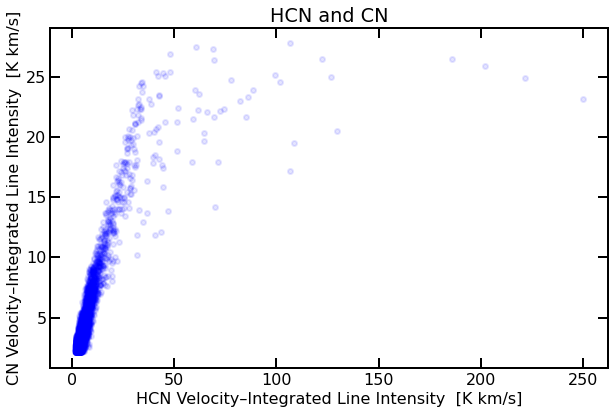

The full width at 10 percent max scaled by the median is  0.9545454545454538


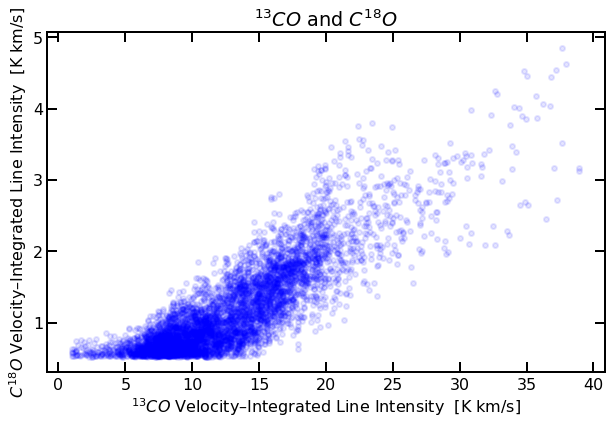

The full width at 10 percent max scaled by the median is  1.0952380952380945


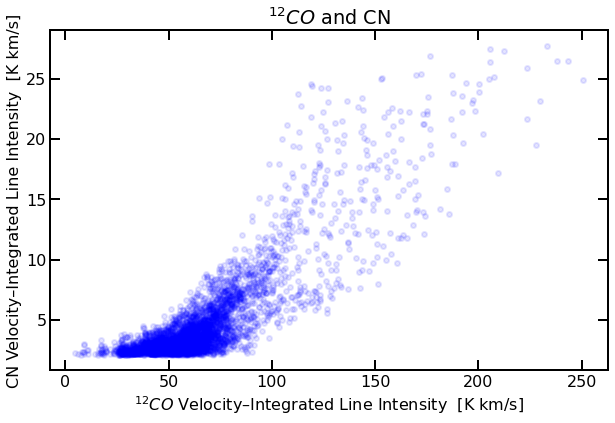

The full width at 10 percent max scaled by the median is  1.1914893617021267


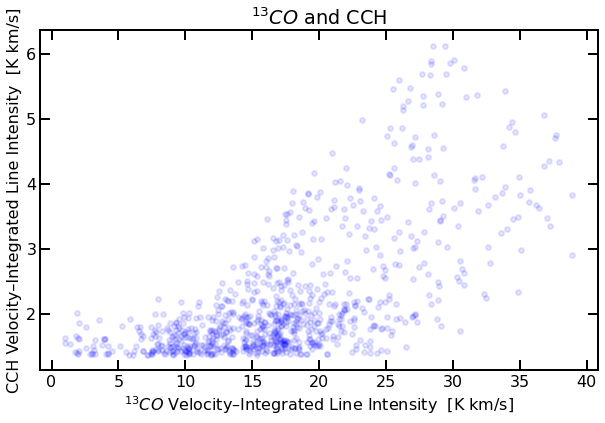

The full width at 10 percent max scaled by the median is  1.2083333333333326


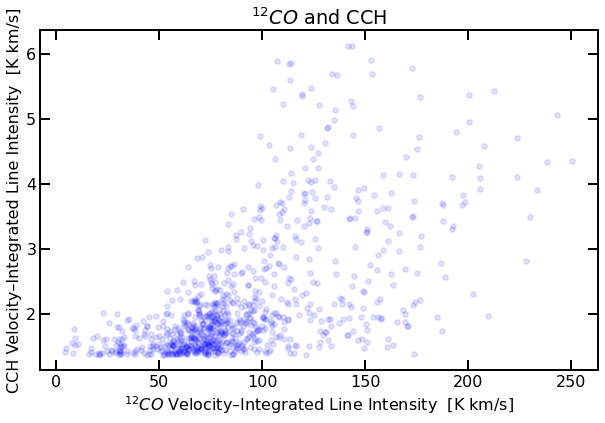

The full width at 10 percent max scaled by the median is  1.2444444444444436


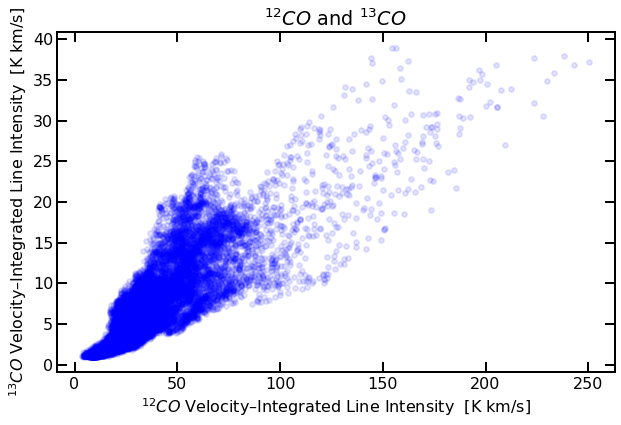

The full width at 10 percent max scaled by the median is  1.3061224489795908


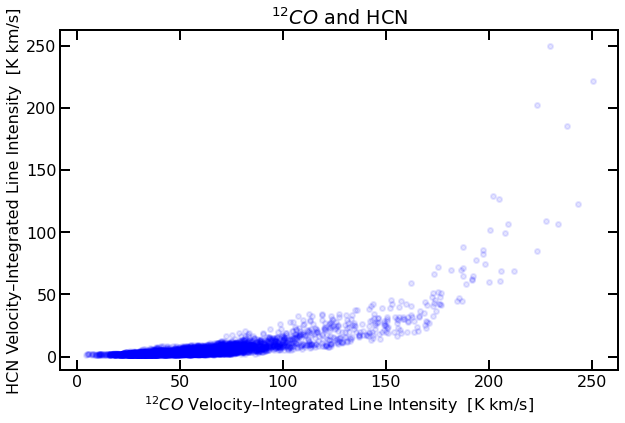

The full width at 10 percent max scaled by the median is  1.319999999999999


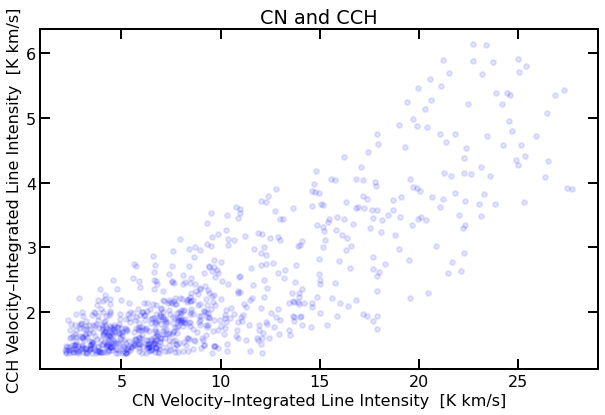

The full width at 10 percent max scaled by the median is  1.4035087719298238


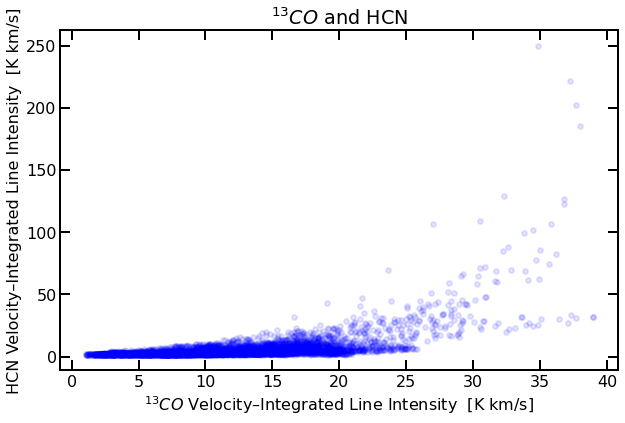

The full width at 10 percent max scaled by the median is  1.4693877551020398


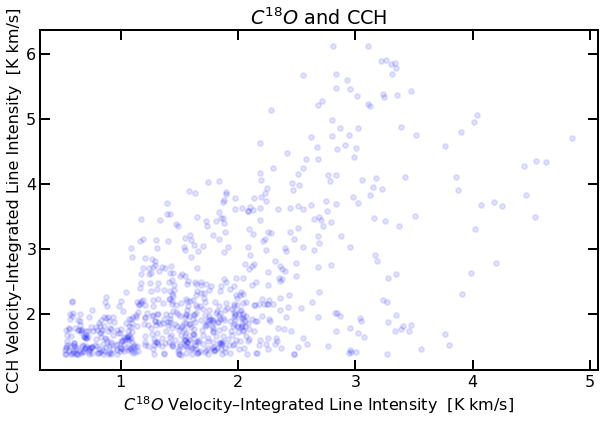

The full width at 10 percent max scaled by the median is  1.4799999999999989


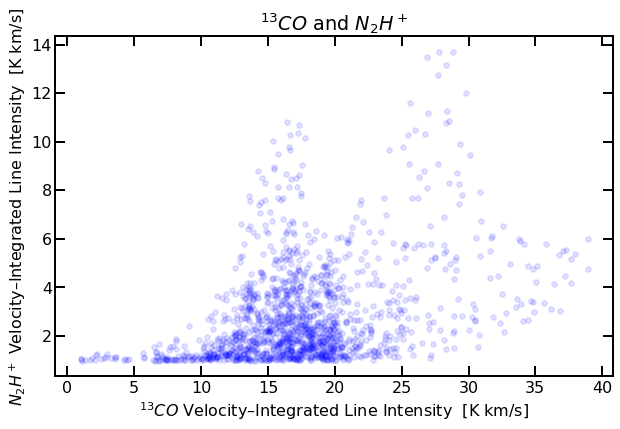

The full width at 10 percent max scaled by the median is  1.5357142857142847


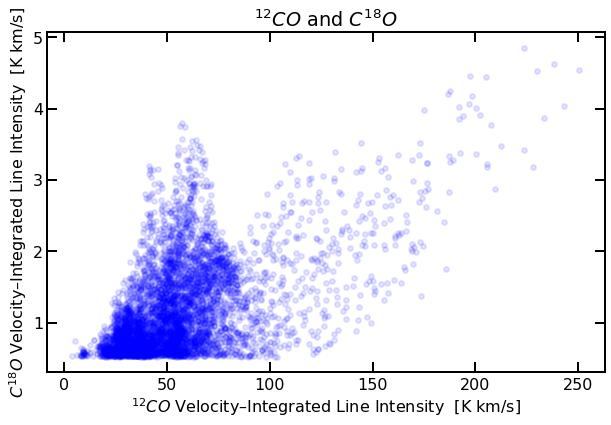

The full width at 10 percent max scaled by the median is  1.5510204081632644


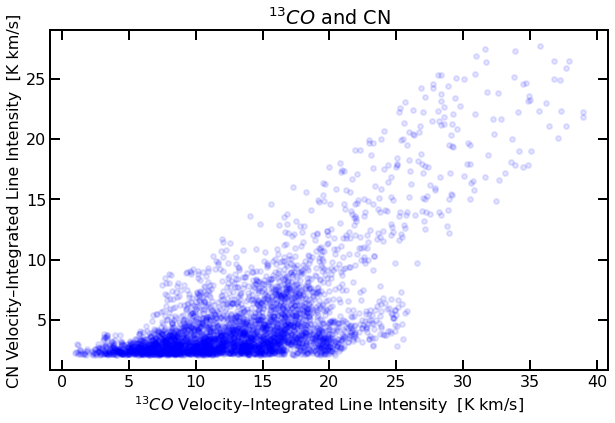

The full width at 10 percent max scaled by the median is  1.5517241379310336


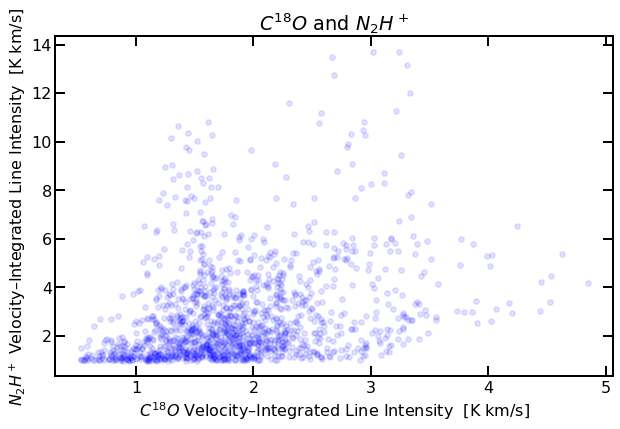

The full width at 10 percent max scaled by the median is  1.5849056603773575


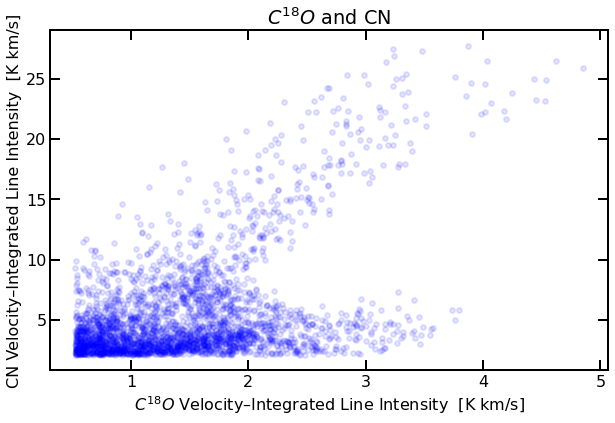

The full width at 10 percent max scaled by the median is  1.6538461538461526


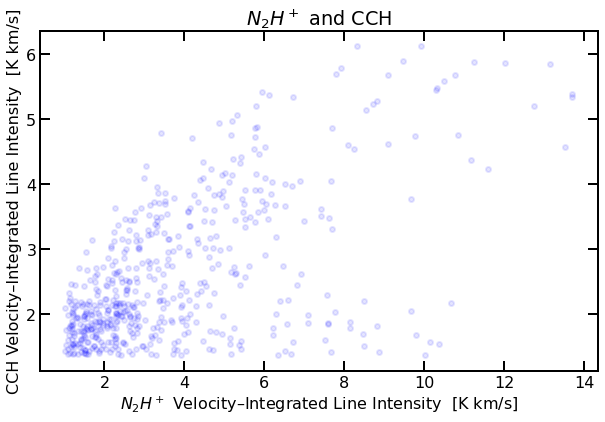

The full width at 10 percent max scaled by the median is  1.6666666666666654


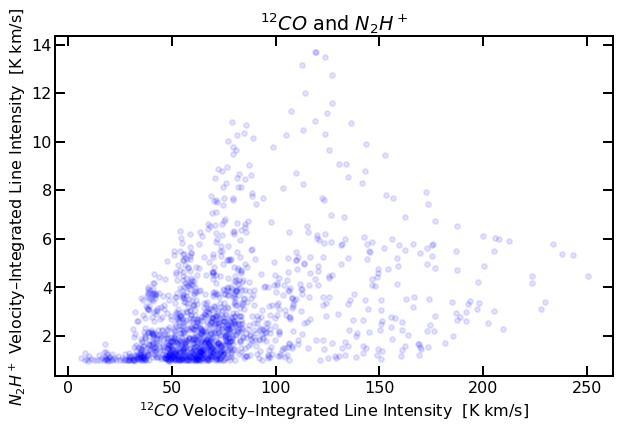

The full width at 10 percent max scaled by the median is  1.727272727272726


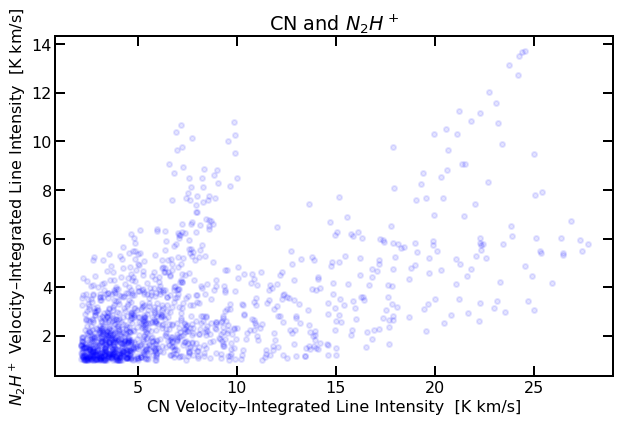

The full width at 10 percent max scaled by the median is  1.7454545454545443


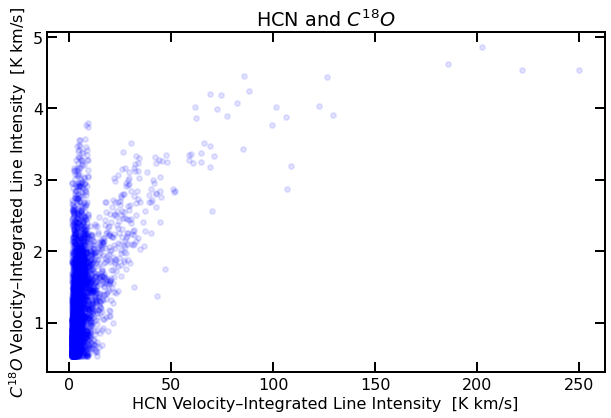

The full width at 10 percent max scaled by the median is  1.8148148148148135


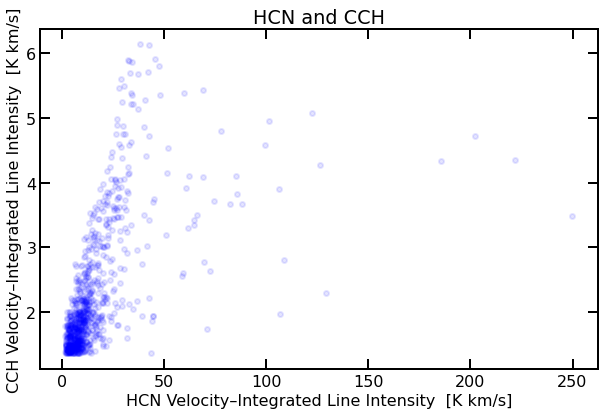

The full width at 10 percent max scaled by the median is  1.8181818181818168


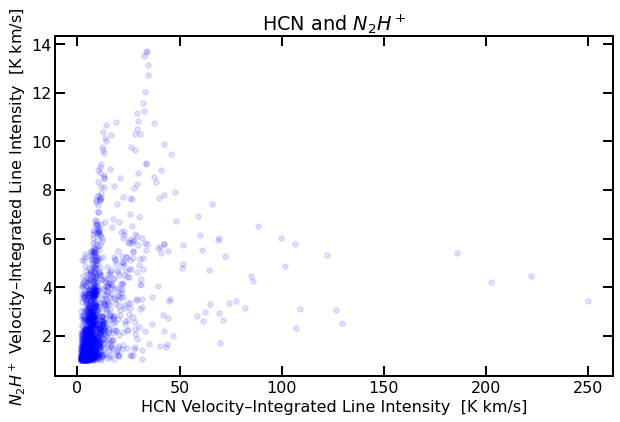

The full width at 10 percent max scaled by the median is  1.8867924528301872


In [9]:
chart_type = 'center_10'    

final_results_array = sorted(results_array, key = lambda x: x["fw10m_scaled_by_median_of_the_bins"])

PlotLimitsY = (1,1)
    
already_done = []

for x in final_results_array:
    plot_scatter_plots(x)
    print("The full width at 10 percent max scaled by the median is  " + str(x["fw10m_scaled_by_median_of_the_bins"]))
    

# Section 4: Comparison

We are going to make a simple normalization of the scatter plots in a function, in order to have all of the scatter plots scaled the exact same way. We are going to do this by finding the 99 percentile, which is basically the value at which 99 percent of the data points is less than. Then we will set the parameters of the plot to this percentile to zoom in on the mass amount of the points.

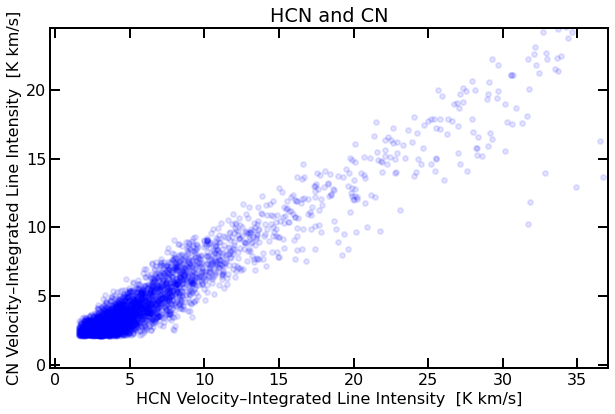

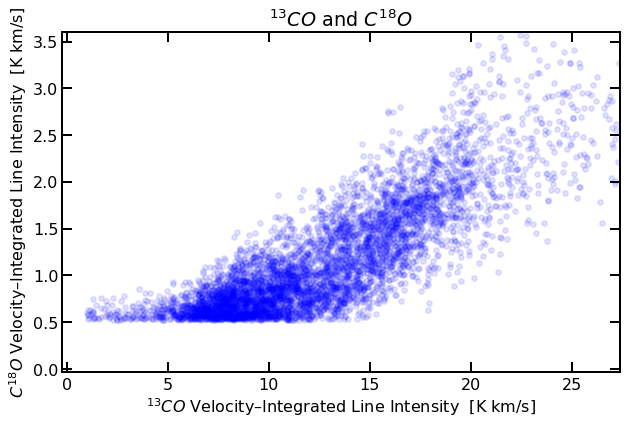

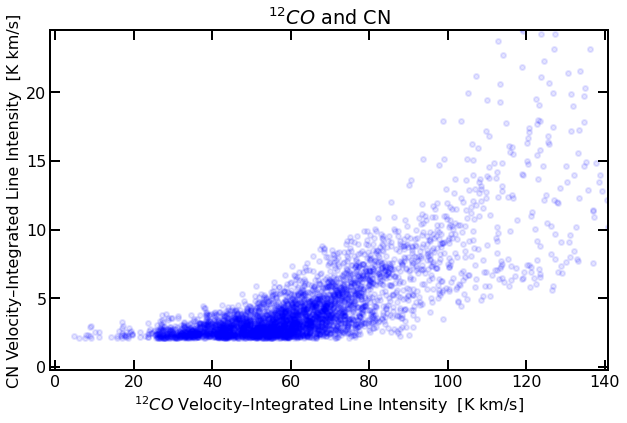

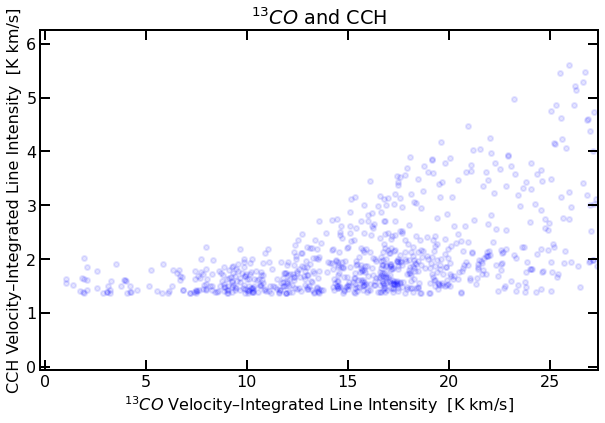

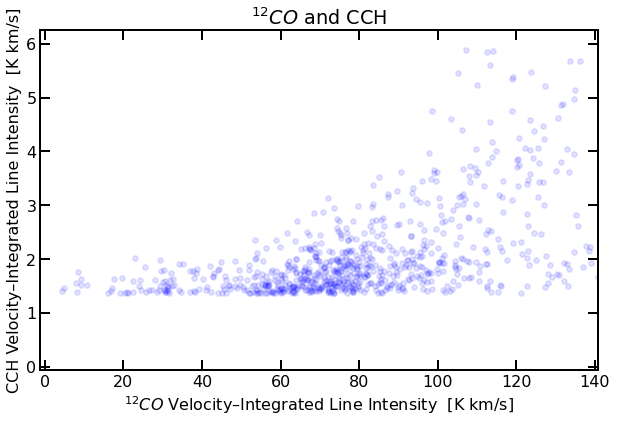

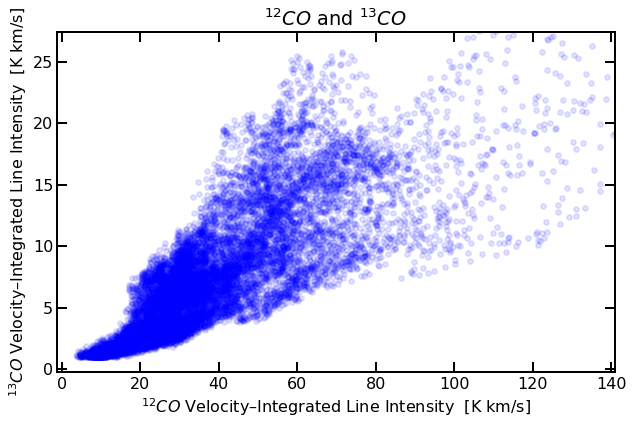

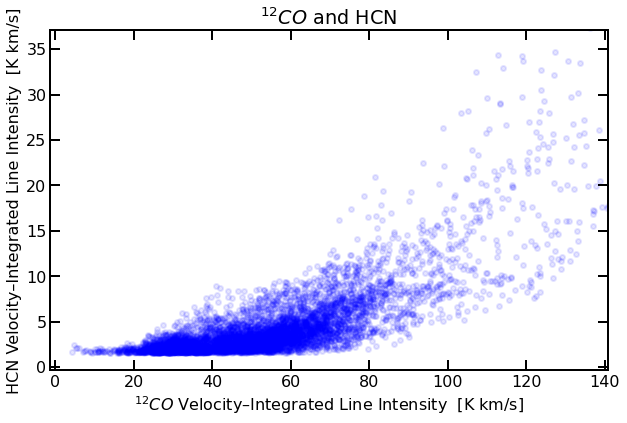

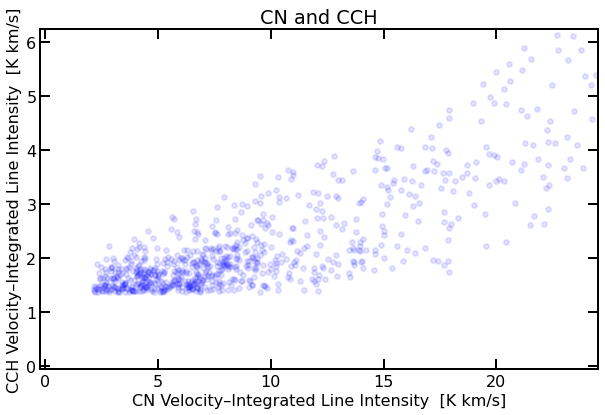

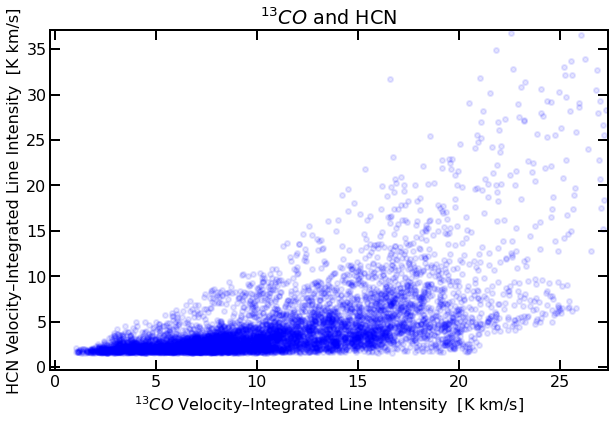

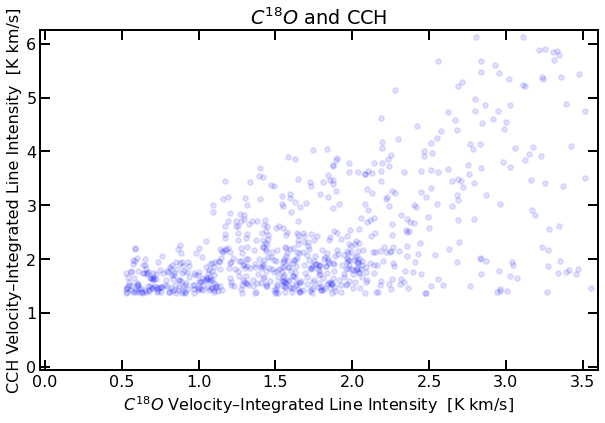

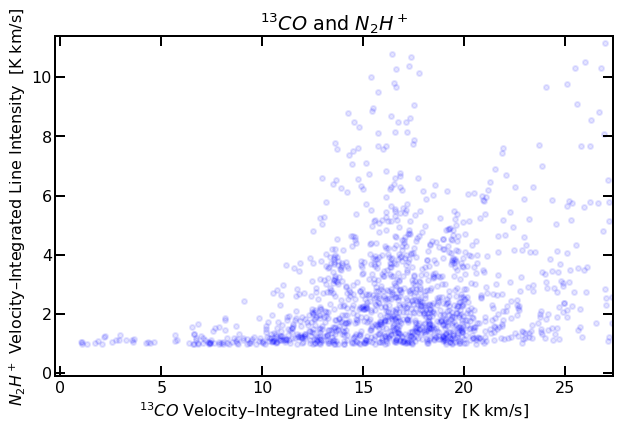

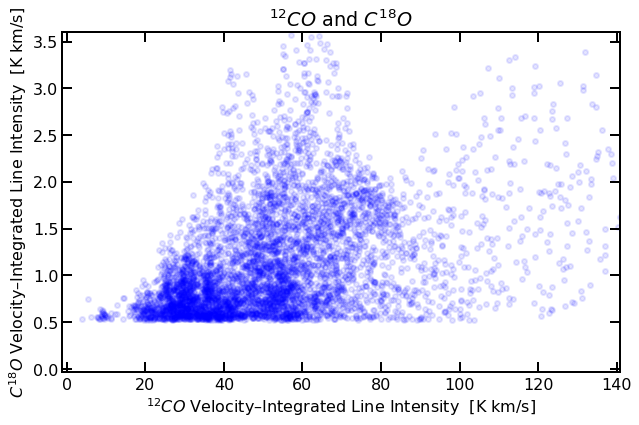

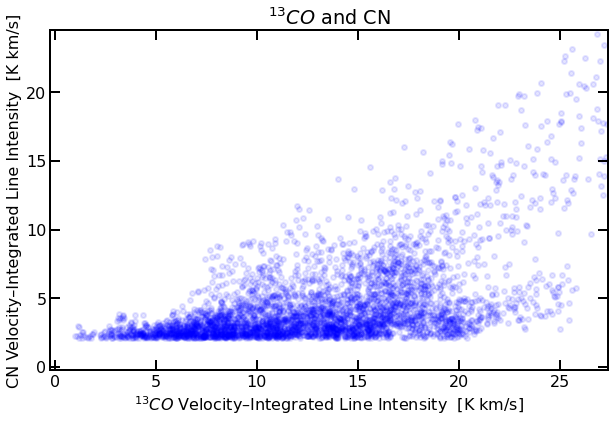

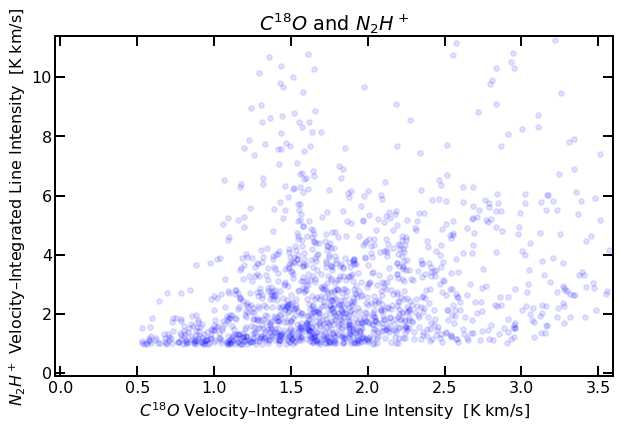

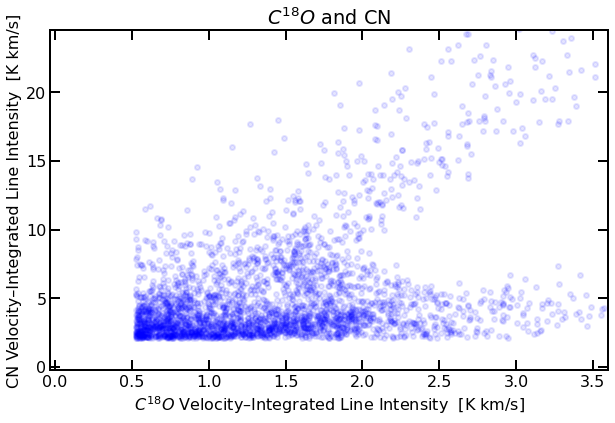

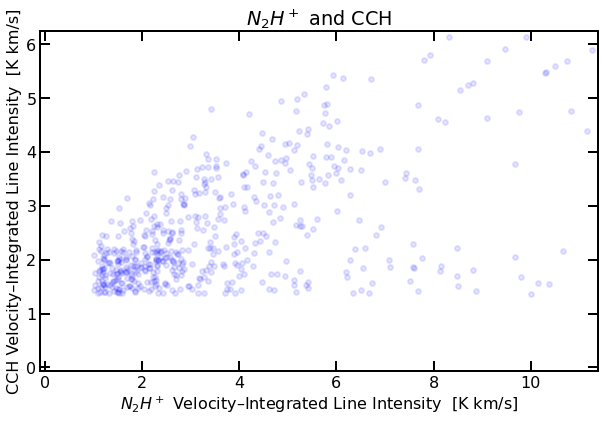

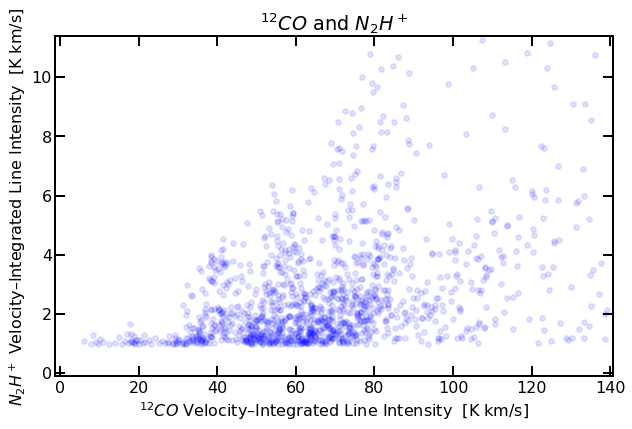

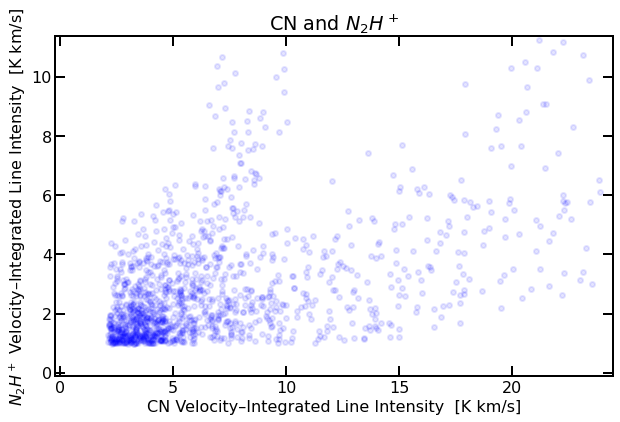

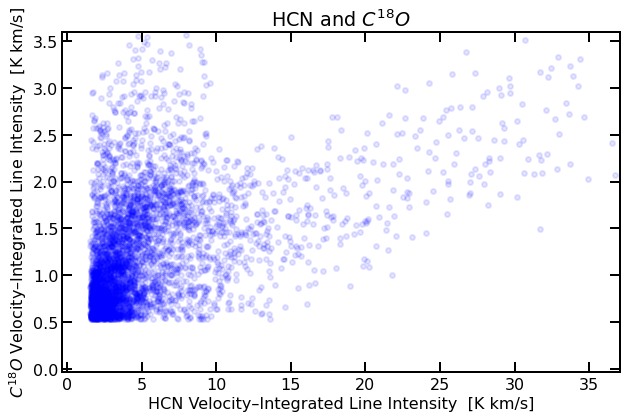

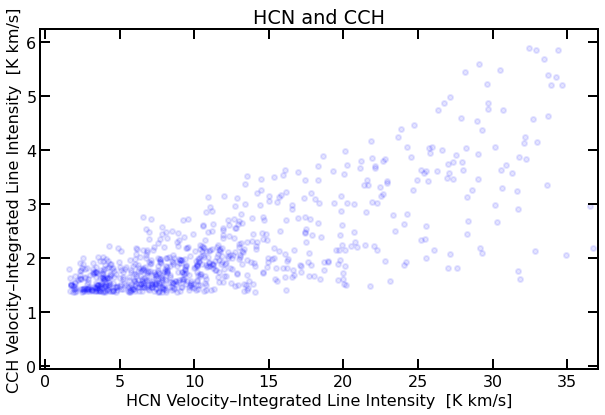

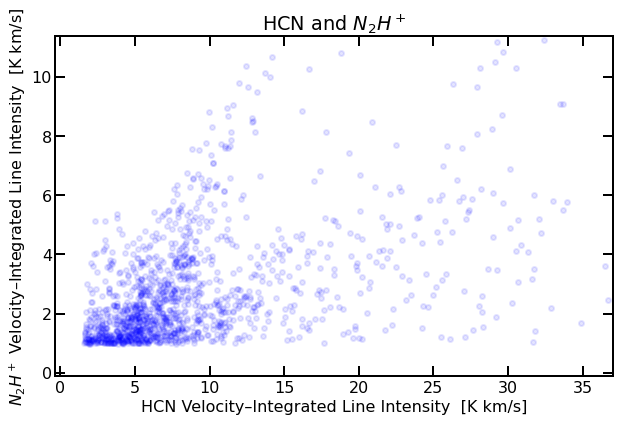

In [10]:
def zoomed_in_scatter_plot(x_array):
    NumberBinsX=180
    x_data = x_array["x_data"]
    y_data = x_array["y_data"]
    
    x_flat = x_data.flatten()
    y_flat = y_data.flatten()

    x_title = x_array["x_label"]
    y_title = x_array["y_label"]
    
    x_percentile = np.nanpercentile(x_flat.tolist(), 99)
    y_percentile = np.nanpercentile(y_flat.tolist(), 99)
    
    plt.figure(1)
    ax = plt.subplot(1,1,1)
    plt.scatter(x_flat, y_flat,
            marker='.', color='blue', alpha = 0.1)
    
    title_text = x_title + ' and ' + y_title
    plt.title(title_text)

    ax.set_xlabel(x_title + " Velocity–Integrated Line Intensity  [K km/s]")
    ax.set_ylabel(y_title + " Velocity–Integrated Line Intensity  [K km/s]")
    
    plt.xlim((-0.01 * x_percentile), (1.1 * x_percentile))
    plt.ylim((-0.01 * y_percentile), (1.1 * y_percentile))
    
    plt.show()

for x in final_results_array:  
    zoomed_in_scatter_plot(x)

Finally, we are going to make a function that displays all three charts: the histogram, scatter plot, and normalized scatter plot.

In [11]:
def display_all_charts(x_array):
    # general
    x_data = x_array["x_data"]
    y_data = x_array["y_data"]
    x_title = x_array["x_label"]
    y_title = x_array["y_label"]
    x_flat = x_data.flatten()
    y_flat = y_data.flatten()
    y_color = x_array['y_color']
    title_text = x_title + ' and ' + y_title

    #fig, (ax1, ax2, ax3) = plt.subplots(1, 2, 3)
    #fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')
    
    # histogram
    plt.subplot(1,3,1)
    Intensity_ratio = x_flat/y_flat
    Median = np.nanmedian(Intensity_ratio)
    Normalized_data = Intensity_ratio/Median
    Histogram1 = np.histogram(Normalized_data, bins=np.arange(-1,10,0.05))
    plot((Histogram1[1][:-1] + Histogram1[1][1:])/2. ,
         (Histogram1[0])/np.nanmax(Histogram1[0]),'-', 
         color=y_color, label=(x_title + " divided by " + y_title))
    title_text = y_title + ' divided by ' + x_title
    plt.title(title_text)
    plt.xlabel('Ratio Intensity')
    plt.ylabel('Density')
    #plt.show()
    #plt.ylim(0,1)
    
    
    # scatter plot
    plt.subplot(1,3,2)
    plt.scatter(x_data, y_data,
            marker='.', color='blue', alpha = 0.05)
    #plt.title(title_text)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    
    # zoomed in scatter plot
    plt.subplot(1,3,3)
    NumberBinsX=180
    x_percentile = np.nanpercentile(x_flat.tolist(), 99)
    y_percentile = np.nanpercentile(y_flat.tolist(), 99)
    #plt.figure(1)
    plt.scatter(x_flat, y_flat,
            marker='.', color='blue', alpha = 0.1)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title("Zoomed Scatter Plot")
    plt.xlim((-0.01 * x_percentile), (1.1 * x_percentile))
    plt.ylim((-0.01 * y_percentile), (1.1 * y_percentile))
    
    plt.show()

    

We run the function through a 'for loop', just like the last couple of programs, and display the full width at ten percent max scaled by the median.

----------------------------------------


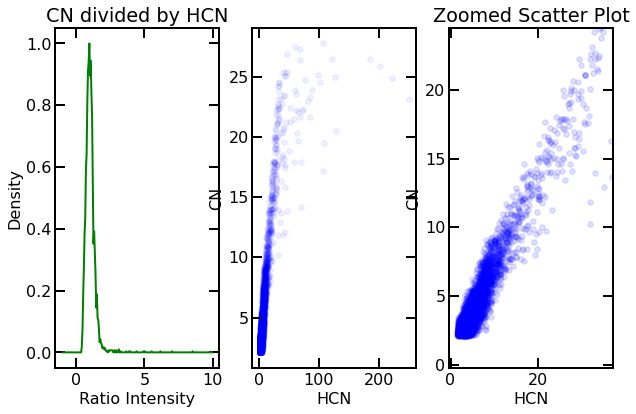

The full width at 10 percent max scaled by the median is  0.9545454545454538
----------------------------------------


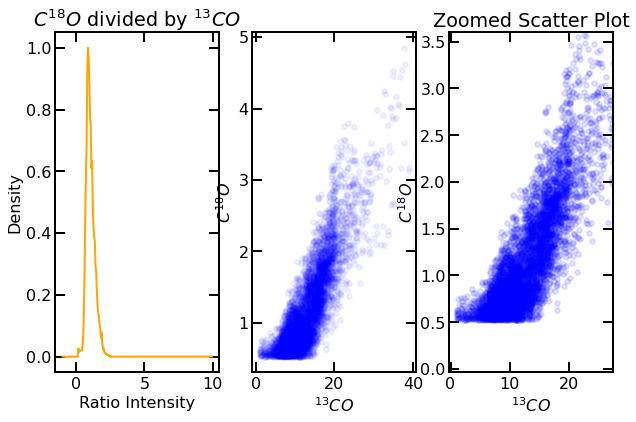

The full width at 10 percent max scaled by the median is  1.0952380952380945
----------------------------------------


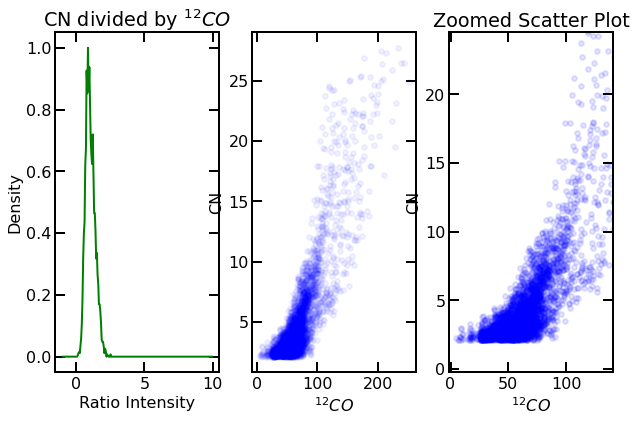

The full width at 10 percent max scaled by the median is  1.1914893617021267
----------------------------------------


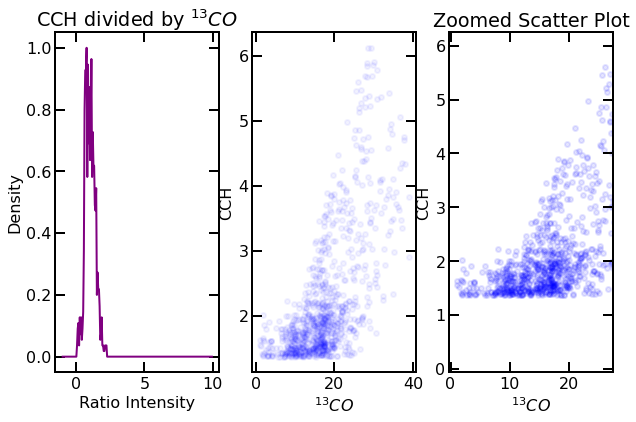

The full width at 10 percent max scaled by the median is  1.2083333333333326
----------------------------------------


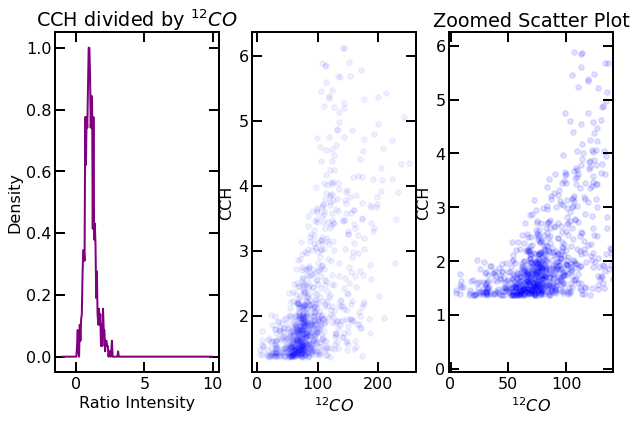

The full width at 10 percent max scaled by the median is  1.2444444444444436
----------------------------------------


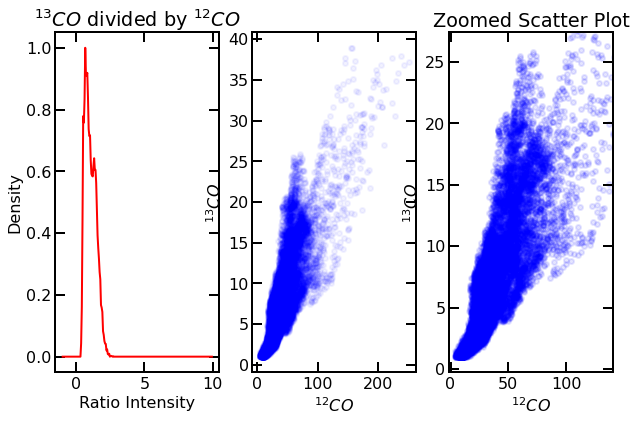

The full width at 10 percent max scaled by the median is  1.3061224489795908
----------------------------------------


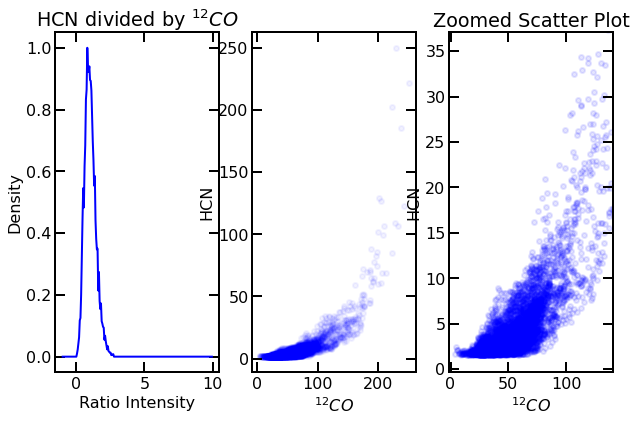

The full width at 10 percent max scaled by the median is  1.319999999999999
----------------------------------------


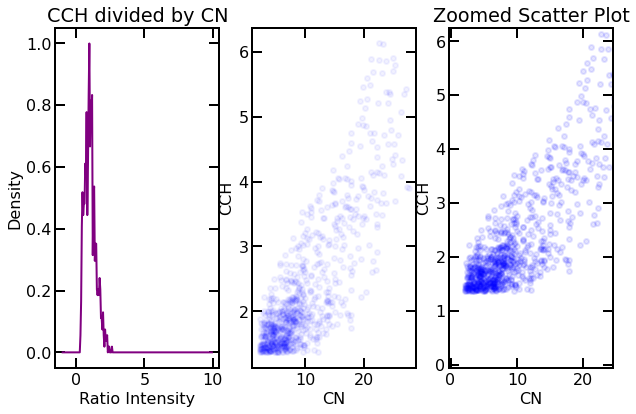

The full width at 10 percent max scaled by the median is  1.4035087719298238
----------------------------------------


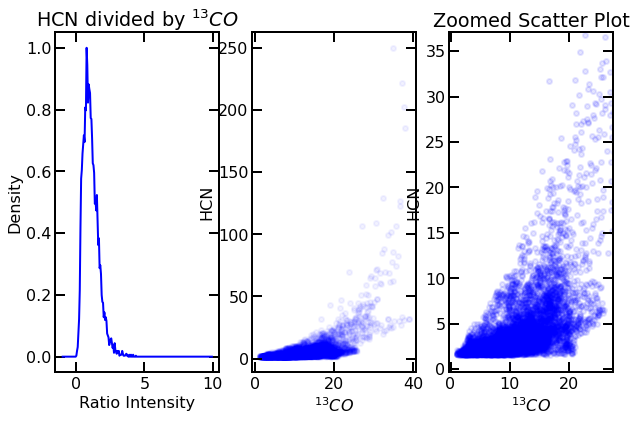

The full width at 10 percent max scaled by the median is  1.4693877551020398
----------------------------------------


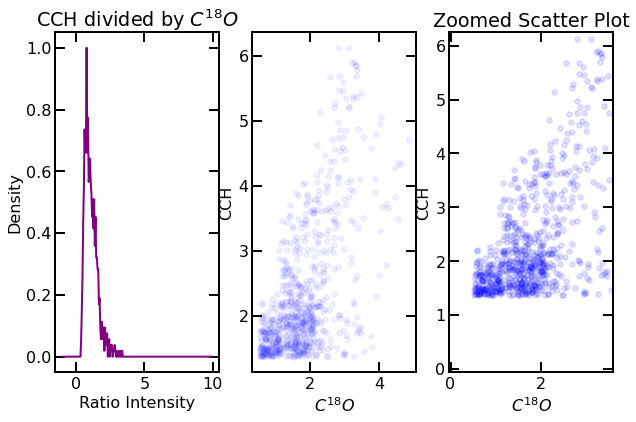

The full width at 10 percent max scaled by the median is  1.4799999999999989
----------------------------------------


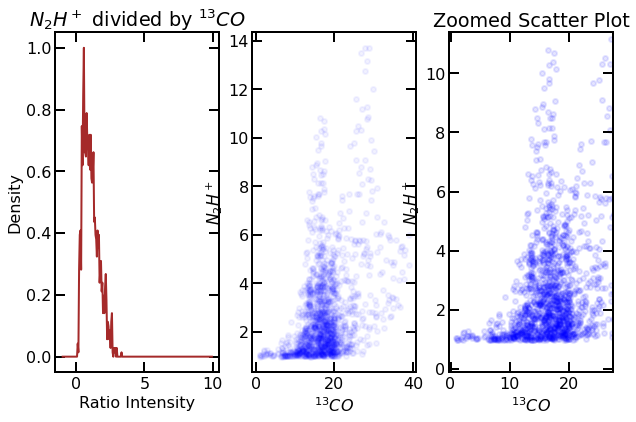

The full width at 10 percent max scaled by the median is  1.5357142857142847
----------------------------------------


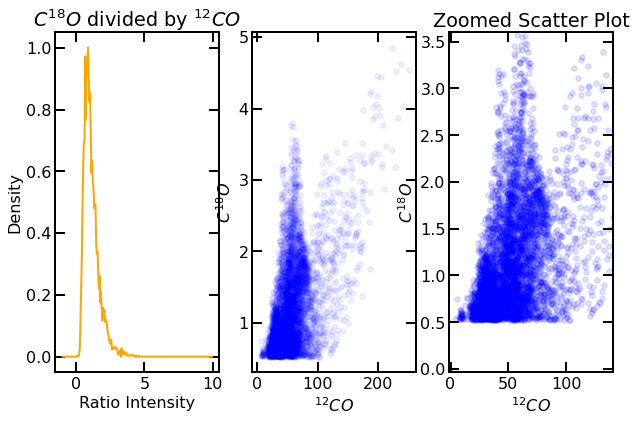

The full width at 10 percent max scaled by the median is  1.5510204081632644
----------------------------------------


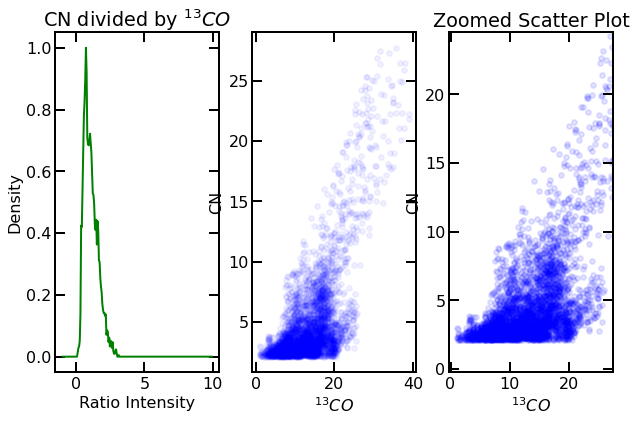

The full width at 10 percent max scaled by the median is  1.5517241379310336
----------------------------------------


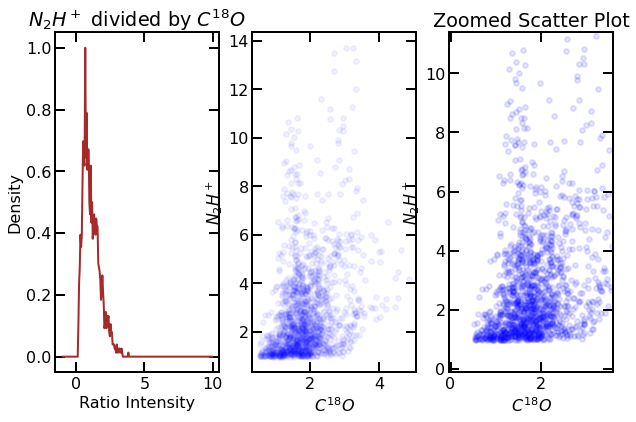

The full width at 10 percent max scaled by the median is  1.5849056603773575
----------------------------------------


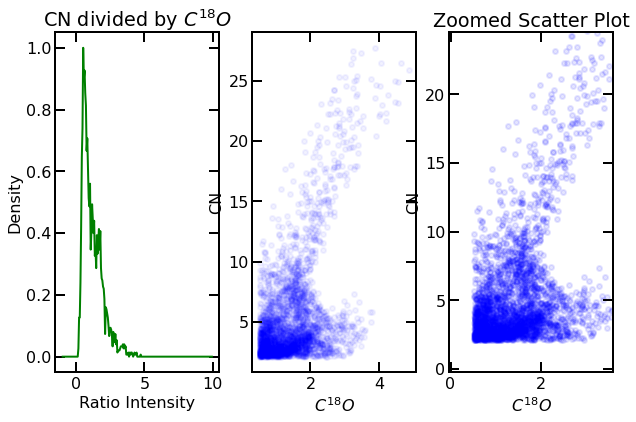

The full width at 10 percent max scaled by the median is  1.6538461538461526
----------------------------------------


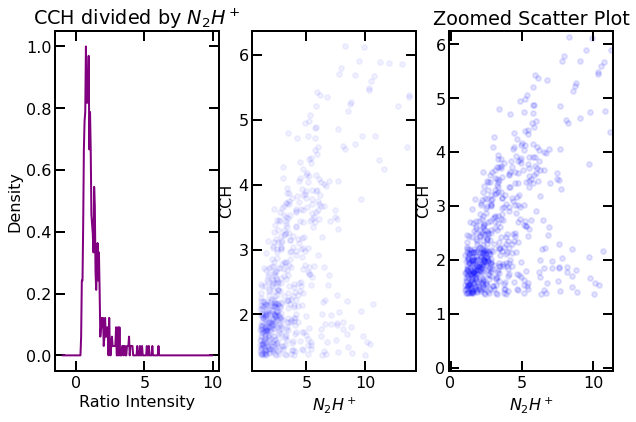

The full width at 10 percent max scaled by the median is  1.6666666666666654
----------------------------------------


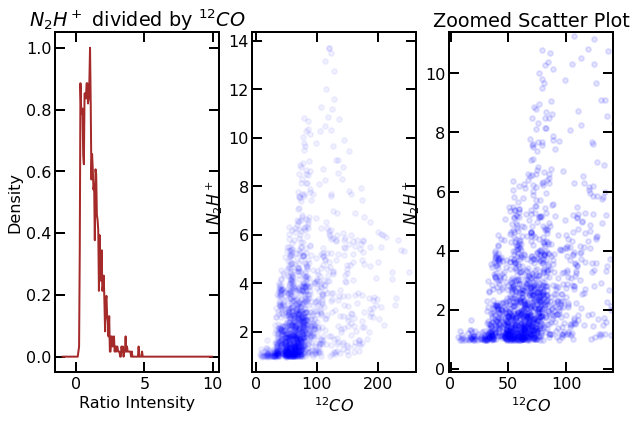

The full width at 10 percent max scaled by the median is  1.727272727272726
----------------------------------------


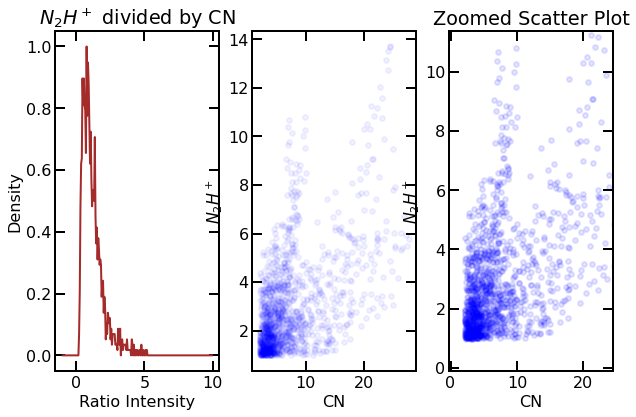

The full width at 10 percent max scaled by the median is  1.7454545454545443
----------------------------------------


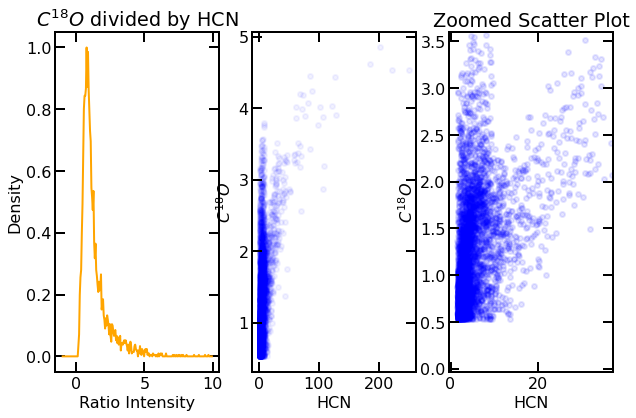

The full width at 10 percent max scaled by the median is  1.8148148148148135
----------------------------------------


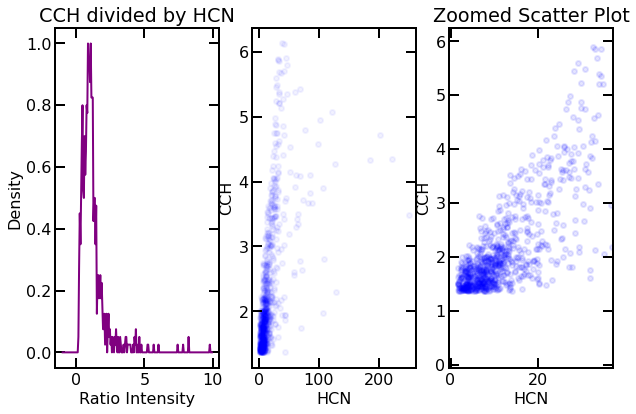

The full width at 10 percent max scaled by the median is  1.8181818181818168
----------------------------------------


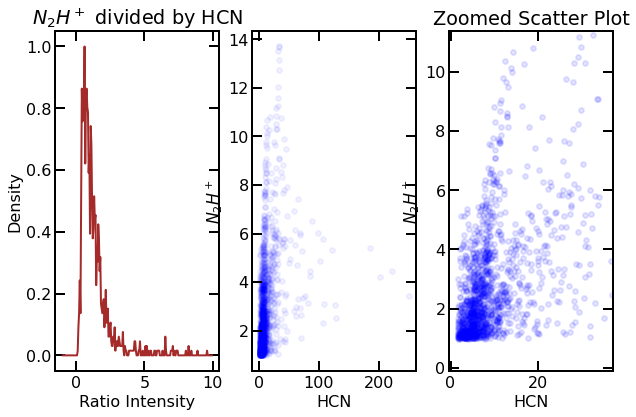

The full width at 10 percent max scaled by the median is  1.8867924528301872


In [13]:
for x in final_results_array:
    print("----------------------------------------")
    display_all_charts(x)
    print("The full width at 10 percent max scaled by the median is  " + str(x["fw10m_scaled_by_median_of_the_bins"]))